**Gaussian Mixture Model**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

In [17]:
def visualization(data, labels):
  labels += 1
  targets = list(set(labels))
  pca_df = PCA(n_components=2)
  pca_df.fit(X)
  principle_components_matrix = pca_df.transform(X)
  for i, u in enumerate(targets):
      xi = [p for (j,p) in enumerate(principle_components_matrix[:,0]) if labels[j] == u]
      yi = [p for (j,p) in enumerate(principle_components_matrix[:,1]) if labels[j] == u]
      plt.scatter(xi, yi)
  plt.title("Clustering results for"+" "+ data +" dataset", fontsize = 15)
  plt.xlabel("Feature 1", fontsize = 10)
  plt.ylabel("Feature 2", fontsize = 10)
  plt.legend(targets)
  plt.show()
def external_index_calc(df, Y, labels):
  TP, TN, FP, FN = 0,0,0,0
  for i in range(len(df)):
      for j in range(len(df)):
          if Y[i] == Y[j]:
              if labels[i] == labels[j]:
                  TP = TP + 1
              else:
                  FN = FN + 1
          elif Y[i] != Y[j]:
              if labels[i] == labels[j]:
                  FP = FP + 1
              else:
                  TN = TN + 1
  jaccard_value = (TP)/(TP + FP + FN)
  rand_value = (TP + TN)/(TP + TN + FP + FN)
  print("Jaccard Coefficient = ", jaccard_value)
  print("Rand Index = ", rand_value)

In [20]:
class GMM:
    def __init__(self, C, n_iters):
      self.C = C
      self.n_iters = n_iters    
          
    def _initialise_parameters(self, X):
      self.shape = X.shape
      self.n, self.m = self.shape

      # if not given
      self._initial_pi = np.full(shape = self.C, fill_value = 1/self.C)
      self.weights = np.full( shape = self.shape, fill_value = 1/self.C)
      random_row = np.random.randint(low = 0, high = self.n, size = self.C)
      self._initial_means = [X[row_index,:] for row_index in random_row]
      self._initial_cov = [np.cov(X.T) for _ in range(self.C)]
      self.smoothing_value = 0.0000001
      self.conv_threshold = 0.00000001

      # if given
#       self._initial_pi = [np.asarray(ele , dtype = float) for ele in [0.5,0.5]]
#       self._initial_means = [np.asarray(ele, dtype = float)for ele in [[0,0],[1,1]]]
#       self._initial_cov = [np.asarray(ele, dtype = float)for ele in [[[1,1],[1,1]],[[2,2],[2,2]]]]
#       self.smoothing_value = 1e-9
#       self.conv_threshold = 1e-9
      return (self._initial_means, self._initial_cov, self._initial_pi)
           
    def _e_step(self, X):
      self.cluster_prob, labels = self.predict(X)
      self.pi = self.cluster_prob.mean(axis=0)
    
    def _m_step(self, X):
      for i in range(self.C):
        weight = self.cluster_prob[:,[i]]
        total_weight = weight.sum()
        self.mu[i] = (X * weight).sum(axis=0) / total_weight
        self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)
        for i , ele in enumerate(self.sigma):
          np.fill_diagonal(self.sigma[i], ele.diagonal() + self.smoothing_value)
    
    def _compute_loss_function(self, X):
      N = X.shape[0]
      L = self.cluster_prob.shape[1]
      self.loss = np.zeros((N, L))
      for c in range(L):
        dist = multivariate_normal(self.mu[c], self.sigma[c], allow_singular = True)
        self.loss[:,c] = self.cluster_prob[:,c] * (np.log(self.pi[c]+0.00000001)+dist.logpdf(X)-np.log(self.cluster_prob[:,c]+0.000000001))
      self.loss = np.sum(self.loss)
      return self.loss
      
    def fit(self, X):
      self.mu, self.sigma, self.pi =  self._initialise_parameters(X)
      loss = None
      for iter in range(self.n_iters):  
        self._e_step(X)
        self._m_step(X)
        calculated_loss = self._compute_loss_function(X)
        if loss != None and abs(calculated_loss - loss) <= self.conv_threshold:
          break
        loss = calculated_loss
     
    def predict(self, X):
      labels = np.zeros((X.shape[0], self.C))    
      for c in range(self.C):
        distribution = multivariate_normal(mean = self.mu[c], cov = self.sigma[c], allow_singular = True)
        labels[:,c] = distribution.pdf(X)
      numerator = labels * self.pi
      denominator = numerator.sum(axis=1)[:,np.newaxis]
      weights = numerator / denominator
      weights1  = weights.argmax(1)
      return weights, weights1 

Enter the file name : iyer
Do you want to enter parameters manually ? 1. Yes 2. No : 1
Enter mu - values separated by | 0,0|1,1
Enter pi - values separated by ,0.5,0.6
Enter sigma - values separated by , and | and ; 1,1|1,1;2,2|2,7


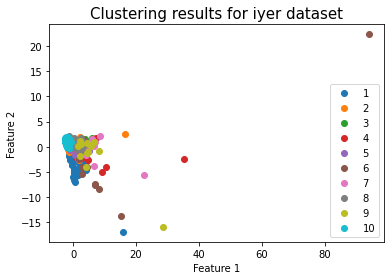

Jaccard Coefficient =  0.33951267467172247
Rand Index =  0.7536673787548309


In [24]:
filename = input("Enter the file name : ")
choice = input("Do you want to enter parameters manually ? 1. Yes 2. No : ")

if choice == '1':
    mu = input("Enter mu - values separated by | ").split("|")
    pi = input("Enter pi - values separated by ,").split(",")
    sigma = input("Enter sigma - values separated by , and | and ; ").split("|")
df = pd.read_csv(filename +'.txt', sep="\t", header=None)
# df = pd.read_csv('/content/drive/My Drive/DM Proj2/'+ i +'.txt', sep=" ", header=None)
X = df.iloc[:,2:]
Y = df.iloc[:,1]
X = np.asarray(X)
Y = np.asarray(Y)
Y1 = [x for x in np.unique(Y) if x > 0]
clusters = len(Y1)
#   gmm = GMM(clusters, n_iters = 100)
gmm = GMM(clusters, n_iters = 100)
gmm.fit(X)
Prob_matrix, predicted_labels = gmm.predict(X)
visualization(filename, predicted_labels)
external_index_calc(df, Y, predicted_labels)